# UTS PPW

## 1. Klasifikasikan berita menggunakan classifier naïve bayes dan SVM

In [1]:
!pip install gensim

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from gensim import corpora, models
from nltk.corpus import stopwords

#  Tambahkan tiga baris ini (agar tokenisasi dan stopword berfungsi)
nltk.download('punkt')
nltk.download('punkt_tab')   # penting untuk versi NLTK baru
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### dataset

In [4]:
import pandas as pd

# Set opsi untuk menampilkan semua baris dan kolom
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Membaca file CSV
df = pd.read_csv('Berita.csv')

# Menampilkan seluruh DataFrame
print(df)

        No                                              judul  \
0        1  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...   
1        2  PT SIER Beri Penghargaan untuk 50 Tenant Terba...   
2        3  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...   
3        4  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...   
4        5  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...   
5        6  AHY Buka-bukaan Nasib Kelanjutan Pembangunan I...   
6        7  Badan Gizi Soal Biaya Makan Gratis Rp10 Ribu: ...   
7        8  Zulhas Minta Tambahan Anggaran Rp510 M Demi Ca...   
8        9             PLN Akan Uji Coba PLTS IKN 22 Desember   
9       10  Profil Jhony Saputra, Anak Haji Isam yang Jadi...   
10      11  Kemendag Dorong UMKM Go Global Lewat Pekan Pen...   
11      12  RDP Perdana, Komisi VI Beri Lampu Hijau Progra...   
12      13  Mendag Pastikan Harga Bapok di Surabaya Stabil...   
13      14  Investasi Pertamina Tembus Rp74 T per Oktober ...   
14      15  Dirut Bulog J

In [5]:
print(df.columns)

Index(['No', 'judul', 'berita', 'tanggal', 'kategori', 'link'], dtype='object')


### preprocessing

In [6]:
import re
import nltk
from nltk.corpus import stopwords

# pastikan stopwords Bahasa Indonesia tersedia
nltk.download('stopwords')

def clean_text(text):
    text = str(text).lower()                          # ubah ke huruf kecil
    text = re.sub(r'[^a-z\s]', '', text)              # hapus simbol & angka
    tokens = text.split()                             # pisahkan kata manual (tanpa nltk)
    stop_words = set(stopwords.words('indonesian'))   # ambil stopword bahasa Indonesia
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

# terapkan ke kolom 'berita'
df['clean_text'] = df['berita'].apply(clean_text)
df = df.dropna(subset=['clean_text', 'kategori'])
print("Jumlah data setelah pembersihan:", len(df))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Jumlah data setelah pembersihan: 1500


,No,judul,berita,tanggal,kategori,link,clean_text
0,1,Airlangga Harap Kenaikan UMP Tingkatkan Daya B...,Menteri Koordinator (Menko) Bidang Perekonomia...,"Minggu, 01 Des 2024 23:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...,menteri koordinator menko bidang perekonomian ...
1,2,PT SIER Beri Penghargaan untuk 50 Tenant Terba...,"Dalam rangka memeriahkan hari jadi ke-50, PT S...","Minggu, 01 Des 2024 20:45 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...,rangka memeriahkan pt surabaya industrial esta...
2,3,Prabowo Bakal Bentuk Kementerian Penerimaan Ne...,Wacana Presiden Prabowo Subianto akan membentu...,"Minggu, 01 Des 2024 19:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...,wacana presiden prabowo subianto membentuk mem...
3,4,Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...,BPJS Ketenagakerjaan dan Kementerian Agama (Ke...,"Minggu, 01 Des 2024 19:03 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...,bpjs ketenagakerjaan kementerian agama kemenag...
4,5,Pemerintah Segera Bentuk Satgas PHK Usai Tetap...,Pemerintah akan segera membentuk Satuan Tugas ...,"Minggu, 01 Des 2024 19:00 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...,pemerintah membentuk satuan tugas pemutusan hu...


### ektraksi modelling LDA

In [7]:
from gensim import corpora, models

In [8]:
texts = [t.split() for t in df['clean_text']]

# Membuat kamus dan corpus untuk LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Model LDA dengan 5 topik (bisa disesuaikan)
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

In [9]:
for idx, topic in lda_model.print_topics(-1):
    print(f"Topik {idx}: {topic}")

Topik 0: 0.018*"indonesia" + 0.012*"timnas" + 0.010*"piala" + 0.009*"pemain" + 0.006*"pelatih" + 0.005*"aff" + 0.005*"red" + 0.005*"laga" + 0.005*"sparks" + 0.005*"tim"
Topik 1: 0.015*"laut" + 0.012*"pagar" + 0.005*"tangerang" + 0.004*"korban" + 0.004*"pt" + 0.004*"desa" + 0.004*"nelayan" + 0.004*"menteri" + 0.003*"kkp" + 0.003*"rp"
Topik 2: 0.011*"persen" + 0.009*"rp" + 0.007*"prabowo" + 0.007*"indonesia" + 0.006*"presiden" + 0.006*"pemerintah" + 0.005*"jakarta" + 0.005*"ppn" + 0.005*"program" + 0.005*"negara"
Topik 3: 0.014*"israel" + 0.008*"senjata" + 0.008*"gencatan" + 0.008*"gaza" + 0.005*"hamas" + 0.005*"palestina" + 0.005*"kpk" + 0.004*"serangan" + 0.004*"menit" + 0.004*"orang"
Topik 4: 0.007*"kebakaran" + 0.005*"yoon" + 0.004*"los" + 0.004*"orang" + 0.004*"indonesia" + 0.004*"angeles" + 0.004*"cnn" + 0.004*"presiden" + 0.003*"banjir" + 0.003*"warga"


### Ubah hasil LDA menjadi vektor fitur

In [10]:
def get_topic_vector(lda_model, corpus):
    topic_features = []
    for doc in corpus:
        topic_dist = [0] * lda_model.num_topics
        for topic_id, prob in lda_model[doc]:
            topic_dist[topic_id] = prob
        topic_features.append(topic_dist)
    return np.array(topic_features)

X_topics = get_topic_vector(lda_model, corpus)
y = df['kategori']

### bagi data train/test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_topics, y, test_size=0.2, random_state=42, stratify=y)

### klasifikasi naive bayes

In [12]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("=== Naive Bayes ===")
print("Akurasi:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

=== Naive Bayes ===
Akurasi: 0.6266666666666667
               precision    recall  f1-score   support

      Ekonomi       0.65      0.77      0.71        75
Internasional       0.55      0.59      0.57        75
     Nasional       0.62      0.39      0.48        75
     Olahraga       0.68      0.76      0.72        75

     accuracy                           0.63       300
    macro avg       0.62      0.63      0.62       300
 weighted avg       0.62      0.63      0.62       300



### klasifikasi dengan SVM

In [13]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("=== SVM ===")
print("Akurasi:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

=== SVM ===
Akurasi: 0.6333333333333333
               precision    recall  f1-score   support

      Ekonomi       0.66      0.81      0.73        75
Internasional       0.54      0.57      0.56        75
     Nasional       0.68      0.35      0.46        75
     Olahraga       0.67      0.80      0.73        75

     accuracy                           0.63       300
    macro avg       0.64      0.63      0.62       300
 weighted avg       0.64      0.63      0.62       300



### bandigkan hasil

In [14]:
hasil = pd.DataFrame({
    'Model': ['Naive Bayes', 'SVM'],
    'Akurasi': [accuracy_score(y_test, y_pred_nb),
                accuracy_score(y_test, y_pred_svm)]
})
print(hasil)

         Model   Akurasi
0  Naive Bayes  0.626667
1          SVM  0.633333


### visualisasi

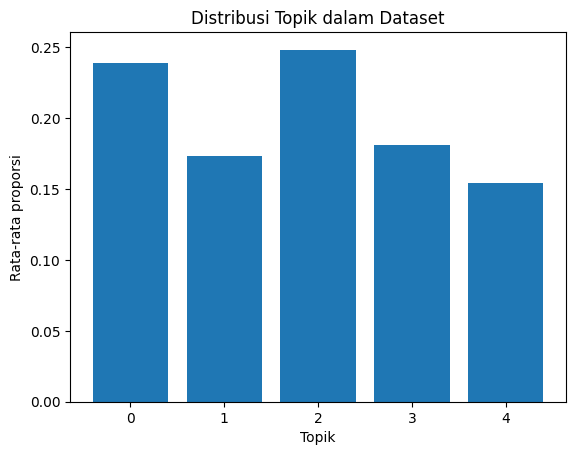

In [15]:
import matplotlib.pyplot as plt

topic_distribution = np.mean(X_topics, axis=0)
plt.bar(range(len(topic_distribution)), topic_distribution)
plt.xlabel('Topik')
plt.ylabel('Rata-rata proporsi')
plt.title('Distribusi Topik dalam Dataset')
plt.show()

## 2. Clustering email

In [16]:
# --- Import Library ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

### Dataset

In [18]:
# --- Baca Dataset (Upload Manual, Auto-Deteksi Kolom) ---
from google.colab import files
import pandas as pd

# Upload file secara manual
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Baca file CSV
df = pd.read_csv(filename, encoding='latin-1')

print("Nama kolom ditemukan:", df.columns.tolist())
print("\nContoh data awal:")
print(df.head())

# --- Pilih kolom teks utama ---
# Kalau kolom 'Text' yang berisi isi email → pakai itu
if 'Text' in df.columns:
    df = df[['Text']].rename(columns={'Text': 'text'})
else:
    # Jika format lain, ambil kolom pertama berisi teks terpanjang
    text_col = df.columns[df.astype(str).apply(lambda x: x.str.len().mean()).idxmax()]
    df = df[[text_col]].rename(columns={text_col: 'text'})

print("\nJumlah data:", len(df))
print("\nContoh teks email:")
print(df['text'].head())


Saving spam.csv to spam (1).csv
Nama kolom ditemukan: ['id', 'Text', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Contoh data awal:
   id                                               Text Unnamed: 2  \
0   1  Go until jurong point, crazy.. Available only ...        NaN   
1   2                      Ok lar... Joking wif u oni...        NaN   
2   3  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   4  U dun say so early hor... U c already then say...        NaN   
4   5  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Jumlah data: 5572

Contoh teks email:
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he go

### preprocessing teks

In [19]:
# --- Preprocessing Teks ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)   # hapus karakter non-huruf
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)

print("Contoh hasil pembersihan teks:")
print(df[['text', 'clean_text']].head())

Contoh hasil pembersihan teks:
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in a wkly comp to win fa cup final ...  
3        u dun say so early hor u c already then say  
4  nah i dont think he goes to usf he lives aroun...  


### tf-idf vectorization

In [20]:
# --- TF-IDF Vectorization ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])

print("Ukuran matriks TF-IDF:", X.shape)

Ukuran matriks TF-IDF: (5572, 1000)


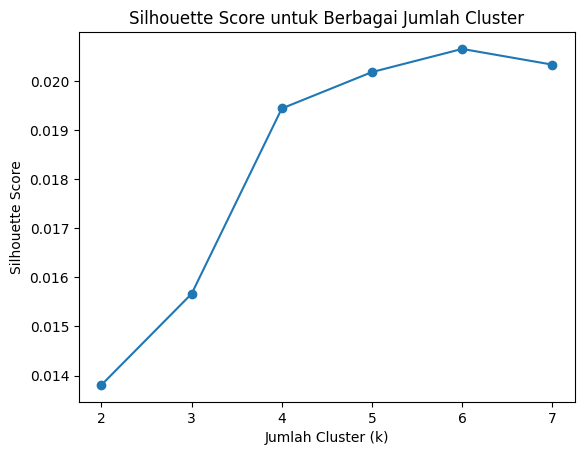

In [21]:
# --- Menentukan Jumlah Cluster Optimal ---
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans_temp.labels_))

plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score untuk Berbagai Jumlah Cluster")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Silhouette Score")
plt.show()

### K-means clustering

In [22]:
# --- K-Means Clustering ---
k = 3  # ubah jumlah cluster sesuai hasil grafik sebelumnya
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

df['cluster'] = kmeans.labels_

print("Jumlah dokumen per cluster:")
print(df['cluster'].value_counts())

Jumlah dokumen per cluster:
cluster
0    4958
2     404
1     210
Name: count, dtype: int64


In [23]:
# --- Contoh Isi Tiap Cluster ---
for i in range(k):
    print(f"\n🌀 Cluster {i}")
    print(df[df['cluster']==i]['text'].head(5).to_string(index=False))


🌀 Cluster 0
Go until jurong point, crazy.. Available only i...
                     Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final...
 U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives arou...

🌀 Cluster 1
Oops, I'll let you know when my roommate's done
             Sorry, I'll call later in meeting.
                         Sorry, I'll call later
    Aight, I'll hit you up when I get some cash
              What time you coming down later? 

🌀 Cluster 2
I'm gonna be home soon and i don't want to talk...
 IÛ÷m going to try for 2 months ha ha only joking
Just forced myself to eat a slice. I'm really n...
I'm back &amp; we're packing the car now, I'll ...
Hello! How's you and how did saturday go? I was...


### visualisasi

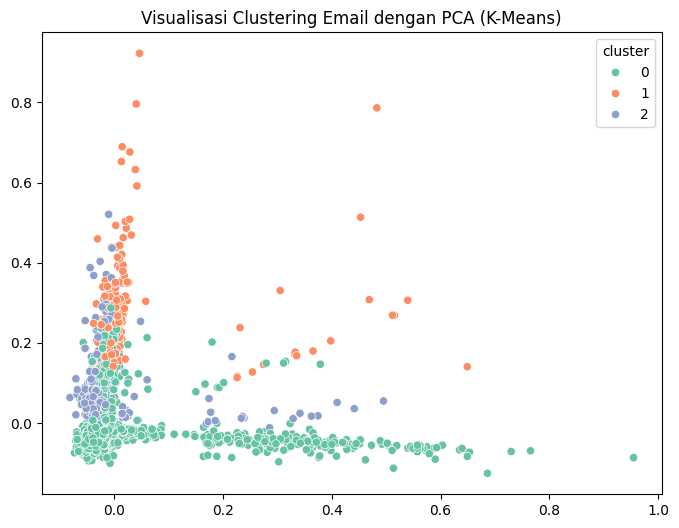

In [24]:
# --- Visualisasi dengan PCA 2D ---
pca = PCA(n_components=2, random_state=42)
reduced_X = pca.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced_X[:,0], y=reduced_X[:,1], hue=df['cluster'], palette='Set2')
plt.title("Visualisasi Clustering Email dengan PCA (K-Means)")
plt.show()

In [25]:
print(df['cluster'].value_counts())

cluster
0    4958
2     404
1     210
Name: count, dtype: int64
